In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
df = pandas.read_csv('Data\RE__Data_for_Degradation\Degradation_45DegC_1C.csv')


In [3]:
df.head()

,Cycle,Capacity %
0,14,99.3075
1,32,98.1534
2,53,96.9988
3,75,96.3050
4,100,95.8413


In [4]:
print(df.columns.tolist())
cycle = np.array(df['Cycle'][:])
capacity = np.array(df['Capacity %'][:])

['Cycle', 'Capacity %']


Text(0.5, 1.0, 'Capacity with number of Cycles')

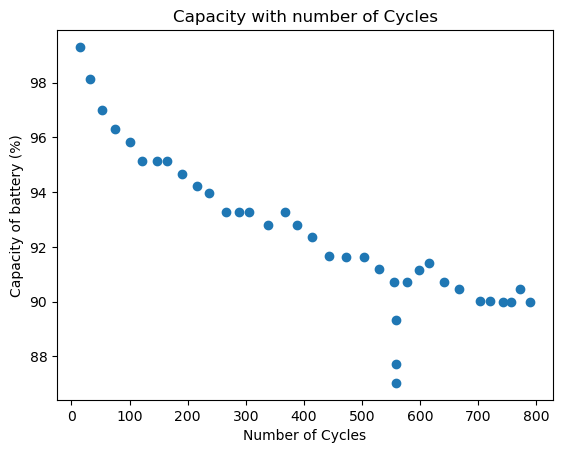

In [5]:
fig, ax = plt.subplots()
ax.scatter(cycle, capacity)
plt.xlabel("Number of Cycles")
plt.ylabel('Capacity of battery (%)')
plt.title("Capacity with number of Cycles")

In [6]:
#remove the weird values
print(capacity)
print(len(capacity))
# Get the indexes of values less than 5
indexes_to_remove = [i for i, val in enumerate(capacity) if val < 90]

# Remove the values less than 5 from both lists
capacity = [val for i, val in enumerate(capacity) if i not in indexes_to_remove]
cycle = [val for i, val in enumerate(cycle) if i not in indexes_to_remove]

capacity = np.array(capacity)
cycle = np.array(cycle)


[99.3075 98.1534 96.9988 96.305  95.8413 95.1476 95.1447 95.1426 94.6788
 94.2151 93.9822 93.2876 93.2851 93.283  92.8185 93.276  92.8126 92.3489
 91.6543 91.651  91.6473 91.1835 90.0094 90.7198 89.3369 87.724  87.0327
 90.7173 91.1756 91.4039 90.7098 90.4765 90.0115 90.0069 90.0052 90.4644
 90.0015]
37


In [7]:
#next step is to convert the number of cycles into Ah
#the capacity is already equal to slosscysle
nom_cap = 2.5 #nominal capaity is 2.5Ah
#charge throughput per cycle is just 2.5Ah, as the DoD is 100%
#however remember each cycle there is degradation, so the nominal capacity reduces
#since we are using a time step of 3600seconds, and our current for 1C is 2.5Ah for the first cycle,
#and therefore our current at 1C is just equal to the capacity, which is reducing
current = 2.5*capacity/100
print(current)
#now our energythroughput per cycle is just our current multiplied by the time step, normalized agsinst the hour
#however we are using a time step of 3600, so the charge throughput is equal to the value in current, in Ah
#therefore at x number of cyces, our charge throughput is just the sum of each cycle
charge_thru = current*cycle
print(charge_thru)



[2.4826875 2.453835  2.42497   2.407625  2.3960325 2.37869   2.3786175
 2.378565  2.36697   2.3553775 2.349555  2.33219   2.3321275 2.332075
 2.3204625 2.3319    2.320315  2.3087225 2.2913575 2.291275  2.2911825
 2.2795875 2.250235  2.267995  2.2679325 2.27939   2.2850975 2.267745
 2.2619125 2.2502875 2.2501725 2.25013   2.26161   2.2500375]
[  34.757625    78.52272    128.52341    180.571875   239.60325
  290.20018    349.6567725  392.463225   449.7243     508.76154
  556.844535   620.36254    671.65272    713.61495    784.316325
  855.8073     902.602535   955.811115  1015.0713725 1081.4818
 1154.75598   1208.181375  1622.419435  1258.737225  1308.5970525
 1363.07522   1407.62006   1455.89229   1508.6956375 1581.9521125
 1671.8781675 1703.34841   1745.96292   1777.529625 ]


Alternative way of going about this

In [8]:
new_capacity = np.insert(capacity, 0, 100)
new_current = []
new_charge_through = []
average_capacity = []
for i in range(len(capacity)):
    average_capacity.append((new_capacity[i] + new_capacity[i+1])/2)
    new_current.append(2.5 * average_capacity[i]/100)
    
    new_charge_through.append(new_current[i] * cycle[i])


new_charge_through = np.round(new_charge_through,4)

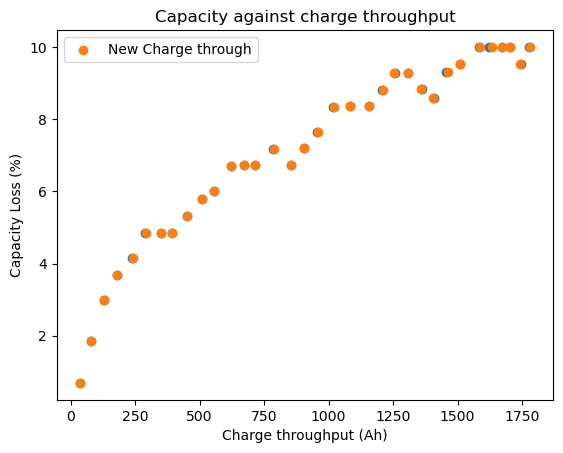

In [9]:
#show the graph as capacity loss

fig, ax = plt.subplots()
ax.scatter(charge_thru, 100-capacity)
plt.xlabel("Charge throughput (Ah)")
plt.ylabel('Capacity Loss (%)')
plt.title("Capacity against charge throughput")

ax.scatter(new_charge_through, 100-capacity, label="New Charge through")
ax.legend()

In [12]:
from scipy.optimize import curve_fit

R = 8.314
T = 318.15
# Eac = 22406

# Define the function to fit the data
def func(Ah, ac, Eac, z): # Equation 5 from Part 4
    return ac * np.exp(-Eac/(8.314*318.15)) * (Ah**z)


# Use curve_fit to estimate the parameters
popt, pcov = curve_fit(func, charge_thru, 100-capacity)

# Print the estimated parameters

ac = popt[0]
Eac = popt[1]
z = popt[2]

print("ac =", popt[0])
print("Eac =", popt[1])
print("z =", popt[2])





ac = 0.7868184104140941
Eac = 2450.8148597312793
z = 0.46703913310384926


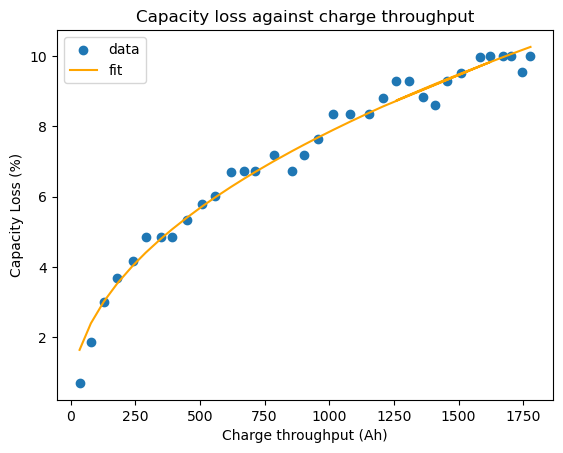

In [14]:
#now lets see the fit
fit_y = func(charge_thru, ac, Eac, z)
fig, ax = plt.subplots()
ax.scatter(charge_thru, 100-capacity, label="data")
plt.plot(charge_thru, fit_y, label="fit", color="orange")
plt.xlabel("Charge throughput (Ah)")
plt.ylabel('Capacity Loss (%)')
plt.title("Capacity loss against charge throughput")
plt.legend()

In [19]:
#now the same for equation 7, the resistance plot
df2 = pandas.read_csv('Data\RE__Data_for_Degradation\Degradation_45DegC_1C_resistance.csv')
print(df2.columns.tolist())
cycle2 = np.array(df2['Cycle'][:])
resistance = np.array(df2['Resistance %'][:])
print(cycle2)
print(resistance)

['Cycle', 'Resistance %']
[  3.3288643 202.24323   393.89163   596.3703    798.8751   ]
[0.6889958  0.73472375 3.0776587  6.8024096  8.688065  ]


In [25]:
#capacity is 2.5Ah
#therefore assume a constant current of 2.5A
#therefore the charge through is just the current multiplied by the time step(3600 in this case)
charge_thru2 = 2.5*cycle2

#and now calculating the coefficients like before:
# Define the function to fit the data
def func2(Ah, ar, Eac):
    return ar * np.exp(-Eac/(8.314*318.15)) * (Ah)


# Use curve_fit to estimate the parameters
popt, pcov = curve_fit(func2, charge_thru2, resistance)

# Print the estimated parameters

ar = popt[0]
Eac2 = popt[1]


print("ar =", popt[0])
print("Eac =", popt[1])


ar = 0.03327508267865926
Eac = 5503.066717838902


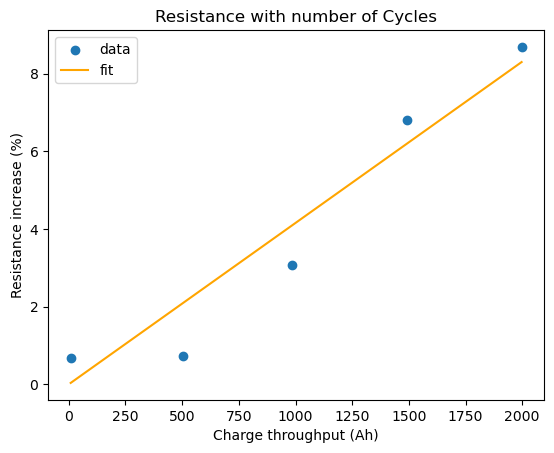

In [26]:
#and now plotting the values
#now lets see the fit
fit_y2 = func2(charge_thru2, ar, Eac2)
fig, ax = plt.subplots()
ax.scatter(charge_thru2, resistance, label="data")
plt.plot(charge_thru2, fit_y2, label="fit", color="orange")
plt.xlabel("Charge throughput (Ah)")
plt.ylabel('Resistance increase (%)')
plt.title("Resistance with number of Cycles")
plt.legend()

### Calendar Ageing Model

In [37]:
#now to the calender aging mdoel
#first import all the data
df3 = pandas.read_excel(r'Data\RE__Data_for_Degradation\Calendar_ageing_60degC_SOC_100.xlsx')
df4 = pandas.read_excel(r'Data\RE__Data_for_Degradation\Calendar_ageing_60degC_SOC_100_resistance_increase.xlsx')
print(df3.columns.tolist())
print(df4.columns.tolist())
Time = np.array(df3['Time(h)'][:])
cap_loss = np.array(df3['Capacity loss %'][:])
Time2 = np.array(df4['Time(h)'][:])
Res_inc = np.array(df4['Resistance increase[%]'][:])

['Time(h)', 'Capacity loss %']
['Time(h)', 'Resistance increase[%]']


In [38]:
#fitting the parameters for the first one, equation 7
R = 8.314
T = 333.15
# Eac = 22406

# Define the function to fit the data
def func3(Time, bc, Eac3, z2):
    return bc * np.exp(-Eac3/(8.314*333.15)) * (Time**z2)


# Use curve_fit to estimate the parameters
popt, pcov = curve_fit(func3, Time, cap_loss)

# Print the estimated parameters

bc = popt[0]
Eac3 = popt[1]
z2 = popt[2]

print("bc =", popt[0])
print("Eac3 =", popt[1])
print("z2 =", popt[2])

bc = 0.8227808191752152
Eac3 = -17.72285929000104
z2 = 0.30355989359583163


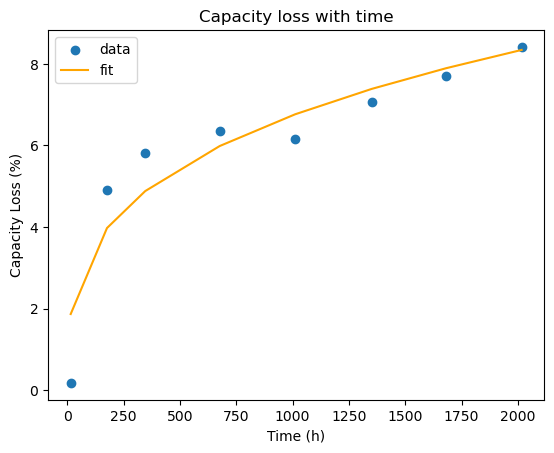

In [39]:
#plot the fit 
fit_y3 = func3(Time, bc, Eac3, z2)
fig, ax = plt.subplots()
ax.scatter(Time, cap_loss, label="data")
plt.plot(Time, fit_y3, label="fit", color="orange")
plt.xlabel("Time (h)")
plt.ylabel('Capacity Loss (%)')
plt.title("Capacity loss with time")
plt.legend()

In [46]:
Res_inc

array([ 0.18239191,  3.8348384 ,  6.940109  , 11.876575  , 15.173212  ,
       22.47762   , 27.4136    , 31.439077  ])

In [63]:
Res_inc

array([ 0.18239191,  3.8348384 ,  6.940109  , 11.876575  , 15.173212  ,
       22.47762   , 27.4136    , 31.439077  ])

In [60]:
#now the same for equation 8
#fitting the parameters for the first one, equation 7
#and now calculating the coefficients like before:
# Define the function to fit the data
##NOTe ****** there is something wrong with this, and part d although I shall check tomorrow

T = 333.15

def func4(Time2, br, Eac4):
    T = 333.15
    return br * Time2 * np.exp(-Eac4/(8.314*T))


# Use curve_fit to estimate the parameters
popt, pcov = curve_fit(func4, Time2, Res_inc, p0 = [1,1], maxfev=10000000,)

# Print the estimated parameters

br = popt[0]
Eac4 = popt[1]


print("br =", popt[0])
print("Eac4 =", popt[1])

br = 57.39721664867876
Eac4 = 158936.97014537768


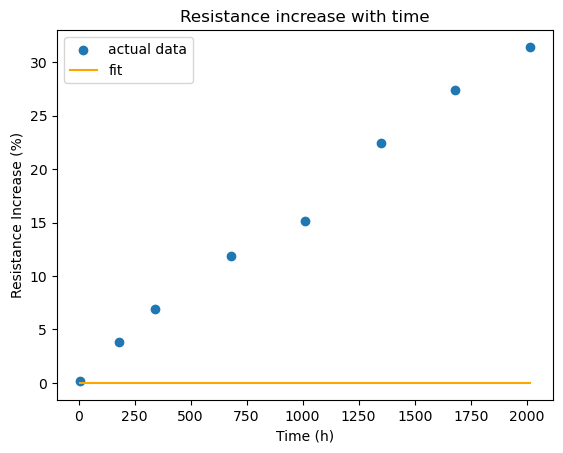

In [61]:
#plot the fit 
fit_y4 = func4(Time2, br, Eac4) # fitted line
fig, ax = plt.subplots()

ax.scatter(Time2, Res_inc, label="actual data")

plt.plot(Time2, fit_y4, label="fit", color="orange")

plt.xlabel("Time (h)")
plt.ylabel('Resistance Increase (%)')
plt.title("Resistance increase with time")
plt.legend()

[10. 20. 30. 40. 50. 60.]


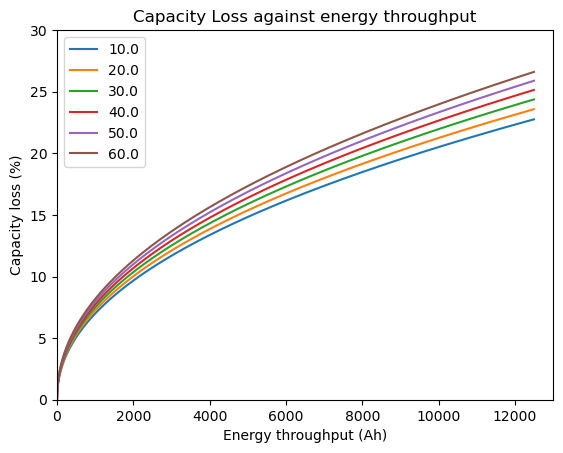

In [62]:
#got all the parameters
#now generating the final plots
#using the parameters found before
#for the first plot, we use equation 5 in the brief
#1 cycle takes 1 hour 
# therefore we have a total of 5000 cycles
#assuming the current is constant at 2.5A
#the total charge throughput = 5000*2.5
charge_thrua = np.linspace(0,5000,5000)
charge_thrua = charge_thrua*2.5
#using the equation with the parameters calculated

T = np.linspace(10,60,6)
print(T)

def func(Ah, ac, Eac, T, z):
    return ac * np.exp(-Eac/(8.314*(T+273.15))) * (Ah**z)

fig, ax = plt.subplots()
for i in T:
    caplossa = func(charge_thrua, ac,Eac, i, z)
    plt.plot(charge_thrua, caplossa, label=i)
    plt.legend()
    plt.title("Capacity Loss against energy throughput")
    plt.xlabel("Energy throughput (Ah)")
    plt.ylabel("Capacity loss (%)")
    plt.ylim(0, 30)
    plt.xlim(0,13000)


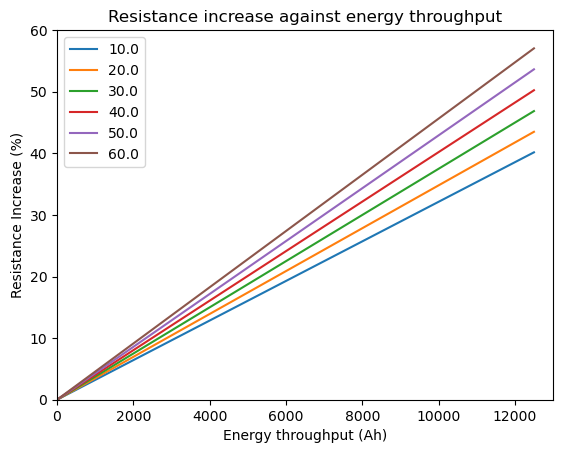

In [43]:
#part b
#using the equation with the parameters calculated


def func2(Ah, ar, Eac, T):
    return ar * np.exp(-Eac/(8.314*(T+273.15))) * (Ah)

fig, ax = plt.subplots()
for i in T:
    resloss = func2(charge_thrua, ar,Eac2, i)
    plt.plot(charge_thrua, resloss, label=i)
    plt.legend()
    plt.title("Resistance increase against energy throughput")
    plt.xlabel("Energy throughput (Ah)")
    plt.ylabel("Resistance Increase (%)")
    plt.xlim(0,13000)
    plt.ylim(0,60)
    

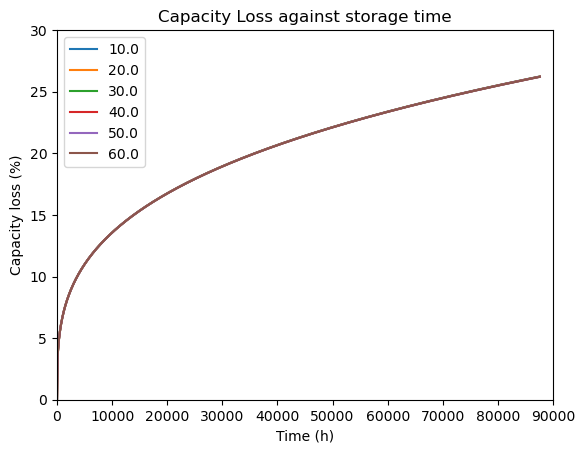

In [44]:
#part c
#10 years
t10 = 10*365*24
time = np.linspace(0,t10,1000)



# Define the function to fit the data
def func3(Time, bc, Eac3, T, z2):
    return bc * np.exp(-Eac3/(8.314*(T+273.15))) * (Time**z2)


fig, ax = plt.subplots()
for i in T:
    caplossc = func3(time, bc, Eac3, i, z2)
    plt.plot(time, caplossc, label=i)
    plt.legend()
    plt.title("Capacity Loss against storage time")
    plt.xlabel("Time (h)")
    plt.ylabel("Capacity loss (%)")
    plt.xlim(0,90000)
    plt.ylim(0,30)

57.415383454483866
158987.28871038486


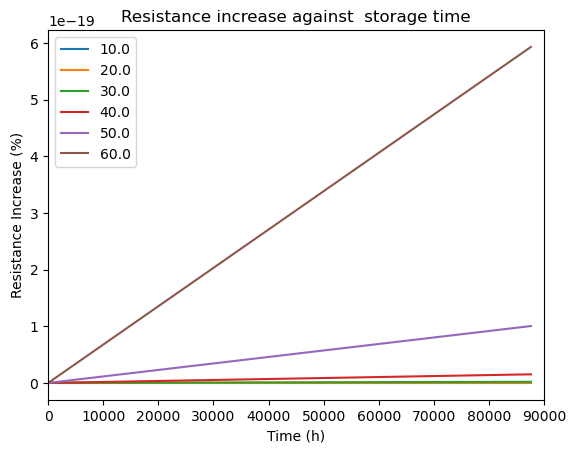

In [45]:

# Define the function to fit the data
def func4(Time2, br, Eac4, T):
    return br * np.exp(-Eac4/(8.314*(T+273.15))) * (Time2)


print(br)
print(Eac4)
fig, ax = plt.subplots()
for i in T:
    reslossd = func4(time, br,Eac4, i)
    plt.plot(time, reslossd, label=i)
    plt.legend()
    plt.title("Resistance increase against  storage time")
    plt.xlabel("Time (h)")
    plt.ylabel("Resistance Increase (%)")
    plt.xlim(0,90000)

    #this is way  too high right?
 
   ##NOTe ****** there is something wrong with this, and part d although I shall check tomorrow